In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [3]:
x_train=x_train.astype("float32")/255.
x_test=x_test.astype("float32")/255.
x_train=tf.expand_dims(x_train,-1)
x_test=tf.expand_dims(x_test,-1)

y_train=tf.one_hot(y_train,depth=10)
y_test=tf.one_hot(y_test,depth=10)

In [4]:
class CNNManual(tf.Module):
    def __init__(self):
        super().__init__()
        initializer = tf.initializers.GlorotUniform()

        self.w1 = tf.Variable(initializer([3, 3, 1, 32]))
        self.b1 = tf.Variable(tf.zeros([32]))

        self.w2 = tf.Variable(initializer([3, 3, 32, 64]))
        self.b2 = tf.Variable(tf.zeros([64]))

        self.w3 = tf.Variable(initializer([7 * 7 * 64, 128]))
        self.b3 = tf.Variable(tf.zeros([128]))

        self.w4 = tf.Variable(initializer([128, 10]))
        self.b4 = tf.Variable(tf.zeros([10]))

    @tf.function
    def __call__(self, x, training=False):
        x = tf.nn.conv2d(x, self.w1, strides=1, padding='SAME') + self.b1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, 2, 2, padding='SAME')
        if training:
            x = tf.nn.dropout(x, rate=0.25)

        x = tf.nn.conv2d(x, self.w2, strides=1, padding='SAME') + self.b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, 2, 2, padding='SAME')
        if training:
            x = tf.nn.dropout(x, rate=0.25)

        x = tf.reshape(x, [-1, 7 * 7 * 64])
        x = tf.nn.relu(tf.matmul(x, self.w3) + self.b3)
        if training:
            x = tf.nn.dropout(x, rate=0.5)

        return tf.matmul(x, self.w4) + self.b4



In [5]:
model = CNNManual()

In [6]:
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam()

train_acc = []
train_loss = []

for epoch in range(20):
    total_loss = 0
    correct = 0
    for i in range(0, len(x_train), 64):
        x_batch = x_train[i:i+64]
        y_batch = y_train[i:i+64]

        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)
            loss = loss_fn(y_batch, logits)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_loss += loss.numpy()
        correct += tf.reduce_sum(tf.cast(tf.argmax(logits, axis=1) == tf.argmax(y_batch, axis=1), tf.float32))

    acc = correct.numpy() / len(x_train)
    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={acc:.4f}")
    train_loss.append(total_loss)
    train_acc.append(acc)


Epoch 1: Loss=253.5142, Accuracy=0.9171
Epoch 2: Loss=95.3367, Accuracy=0.9696
Epoch 3: Loss=71.7230, Accuracy=0.9769
Epoch 4: Loss=61.7264, Accuracy=0.9801
Epoch 5: Loss=53.9338, Accuracy=0.9826
Epoch 6: Loss=48.2752, Accuracy=0.9843
Epoch 7: Loss=44.2252, Accuracy=0.9853
Epoch 8: Loss=41.2028, Accuracy=0.9862
Epoch 9: Loss=38.5884, Accuracy=0.9875
Epoch 10: Loss=34.8538, Accuracy=0.9888
Epoch 11: Loss=31.6924, Accuracy=0.9894
Epoch 12: Loss=30.3705, Accuracy=0.9894
Epoch 13: Loss=29.7121, Accuracy=0.9897
Epoch 14: Loss=28.7549, Accuracy=0.9899
Epoch 15: Loss=27.7760, Accuracy=0.9901
Epoch 16: Loss=27.7150, Accuracy=0.9904
Epoch 17: Loss=23.3183, Accuracy=0.9918
Epoch 18: Loss=24.2856, Accuracy=0.9920
Epoch 19: Loss=25.2845, Accuracy=0.9916
Epoch 20: Loss=22.6910, Accuracy=0.9924


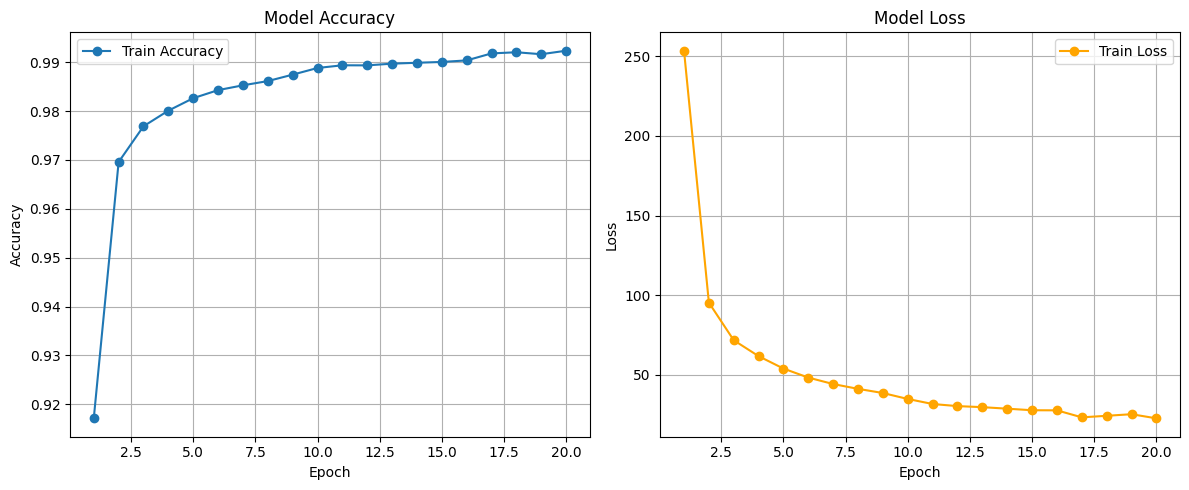

In [7]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', color='orange', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
